In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# Importing necessary modules and functions from your files
from GIANTS_data_load_and_preprocessing import load_data, preprocess_data
from GIANTS_kano_analysis import (get_feature_names, prepare_kano_data, apply_kano_scoring, calculate_kano_averages, plot_kano_results, 
                                  plot_kano_by_age_group, plot_feature_means_with_std
)
from GIANTS_survey_demographics import plot_age_distribution, plot_market_distribution, plot_income_distribution, plot_user_type_distribution
from GIANTS_clustering import preprocess_for_clustering, perform_clustering, visualize_clusters_with_pca, plot_elbow_method, analyze_survey_responses_by_cluster



# Step 1: Load the data
file_path = "C:/Users/TomiNordi2m/OneDrive - i2m Unternehmensentwicklung GmbH/Documents/Python/GIANTS Survey Data Analysis/Copy of 2024.09.12 GIANTS project_ User and stakeholder needs survey (Responses).xlsx"
df = load_data(file_path)

# Step 2: Preprocess the data
df = preprocess_data(df)


# Step 3: Prepare Kano data
df_kano = prepare_kano_data(df)

# Step 4: Get feature names for Kano analysis
feature_names = get_feature_names()



# Step 5: Apply Kano scoring
df_kano = apply_kano_scoring(df_kano, feature_names)

# Step 6: Calculate Kano averages
df_averages = calculate_kano_averages(df_kano, feature_names)

# Step 7: Plot Kano results 
plot_kano_results(df_averages)






['Timestamp', 'GENDER', 'AGE', 'COUNTRY', 'CITY', '5. What is the population where you live? (*If you are completing this survey as a fleet operator, public authority, etc. the population of the primary city of your operations / city you represent)', 'USER TYPE', 'EDUCATION', '8. How many people  / family members live in your household? (for safety related questions) [Adults (18 and older)]', '8. How many people  / family members live in your household? (for safety related questions) [Kids (6-17)]', '8. How many people  / family members live in your household? (for safety related questions) [Toddlers (1-5)]', '8. How many people  / family members live in your household? (for safety related questions) [Infants (younger than 1)]', 'INCOME', '10. Please indicate the typical elevation profile of the areas where you drive most frequently. Choose the option that best describes the terrain:', '11. Road quality: What type of terrain do you primarily drive on? Please select the option that best

In [2]:
def plot_kano_results_with_errors(df_averages, plot_title='Kano Model with Errors'):
    """Plots Kano results using Plotly with error bars for functional and dysfunctional scores."""
    fig = px.scatter(df_averages,
                     x='Average Dysfunctional Score',
                     y='Average Functional Score',
                     text='Feature', 
                     title=plot_title,
                     error_x='Dysfunctional StdDev',  # Add standard deviation for dysfunctional scores
                     error_y='Functional StdDev')  # Add standard deviation for functional scores

   

# Step 6: Calculate Kano averages
df_averages = calculate_kano_averages(df_kano, feature_names)


# Step 7: Plot Kano results with standard deviations
plot_kano_results(df_averages)


In [3]:
#plot_interactive_scatter_for_feature(df_kano, 'Doors')

c:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\GIANTS Survey Data Analysis\GIANTS_kano_analysis.py:91: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.

c:\Users\TomiNordi2m\OneDrive - i2m Unternehmensentwicklung GmbH\Documents\Python\GIANTS Survey Data Analysis\GIANTS_kano_analysis.py:95: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.



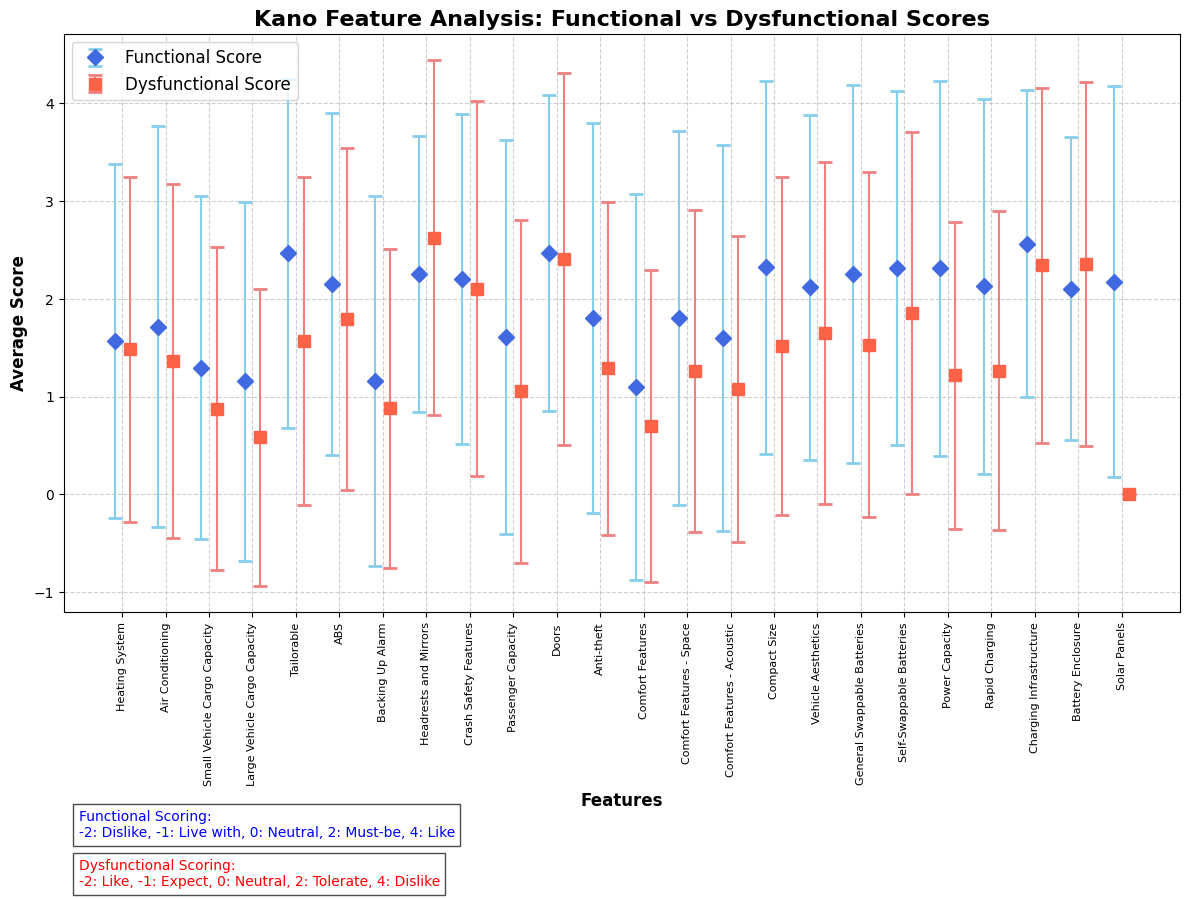

In [4]:
#Standard Deviations of Features
plot_feature_means_with_std(df_averages)


In [5]:
# Step 8: Plot Kano analysis for each age group (set show_plot to False to avoid showing)
#plot_kano_by_age_group(df, df_kano, feature_names)

In [6]:
#kano_analysis_for_students(df, df_kano, feature_names)

In [7]:

# Step 9: Plot the market distribution
#plot_market_distribution(df)


# Plot age distribution
#plot_age_distribution(df)

# Plot income distribution
#plot_income_distribution(df)

#Plot user type distribution
#plot_user_type_distribution(df)


#df = apply_persona_classification(df)

# Print the first few rows to check the classified personas
#print(df[['Persona']].head(20))

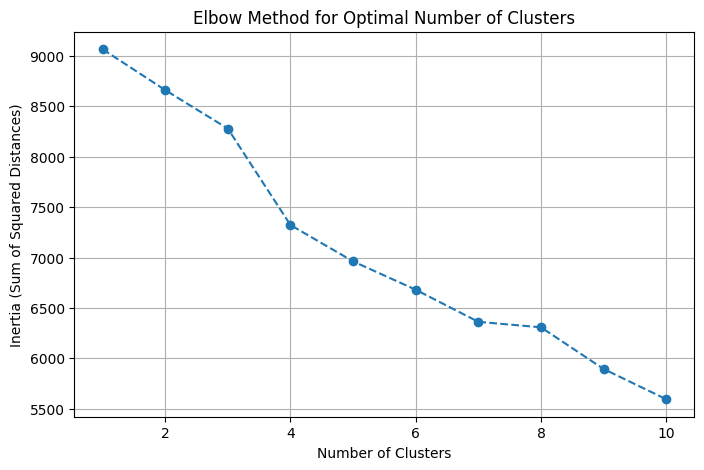

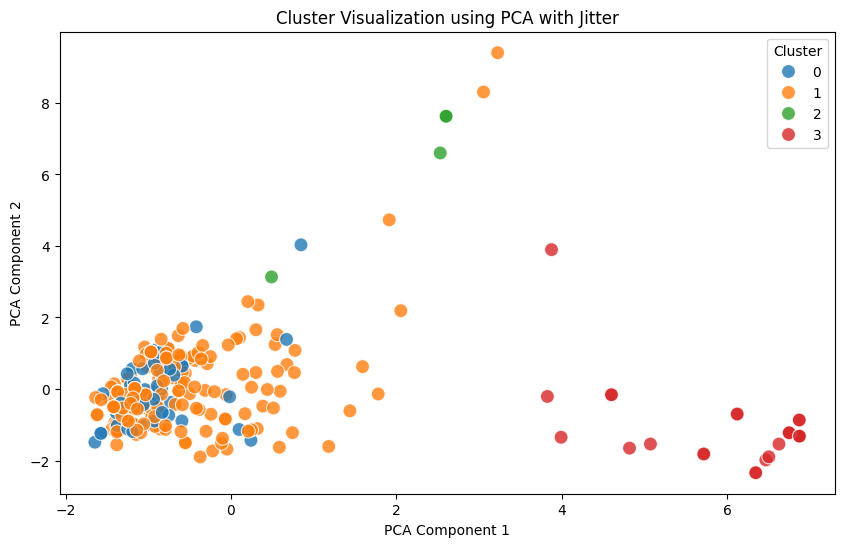

Number of points plotted: 259


In [8]:
# Preprocess specifically for clustering (inside the clustering module)
df_scaled, df_encoded = preprocess_for_clustering(df)

# Perform clustering
df_with_clusters = perform_clustering(df_scaled, df_encoded)

# Plot the elbow method to find the optimal number of clusters
plot_elbow_method(df_scaled, max_clusters=10)

# Visualize clusters (optional)
visualize_clusters_with_pca(df_scaled, df_with_clusters)

# Assuming you have already performed clustering and added the 'cluster' column:
df_with_clusters = perform_clustering(df_scaled, df_encoded, n_clusters=4)

# Now, analyze the survey responses by cluster
analyze_survey_responses_by_cluster(df_with_clusters)
